In [1]:
import pickle
from pathlib import Path
DATA_DIR = Path('')
def load(filename):
    f = open(DATA_DIR/filename,"rb")
    return pickle.load(f)
    
def save(data, filename):
    with open(DATA_DIR/filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
from aoc_utils import *
import tarfile
fname = 'synacor-challenge.tgz'
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
elif fname.endswith("tgz"):
    tar = tarfile.open(fname, "r:gz")
tar.extractall()
tar.close()


res 0


SystemExit: 

In [21]:
import numpy as np

f = open('challenge.bin', 'rb')
ins = np.fromfile(f, dtype=np.uint16)


class Comp():
    def __init__(self, ins, verbose=False):
        self.pnt = 0
        self.ins = ins
        self.functions = {
            0 : (self.halt,0,0),
            1 : (self.set,1,1),
            2 : (self.push,0,1),
            3 : (self.pop,1,0),
            4 : (self.eq,1,2),
            5 : (self.gt,1,2),
            6 : (self.jmp, 0,1),
            7 : (self.jt, 0,2),
            8 : (self.jf, 0,2),
            9 : (self.add, 1,2),
            10 : (self.mult, 1,2),
            11 : (self.mod, 1,2),
            12: (self.func_and, 1,2),
            13 : (self.func_or, 1,2),
            14 : (self.func_not, 1,1),
            15 : (self.rmem, 1,1),
            16 : (self.wmem, 0,2),
            17 : (self.call, 0,1),
            18 : (self.ret, 0,0),
            19: (self.out,0,1),
            20: (self.func_in,1,0),
            21: (self.noop,0,0),
        }
        self.M = 32768
        self.reg = {i:0 for i in range(8)}
        self.stack = []
        self.verbose = verbose
        self.in_loc = 0
        self.hunting = False

    def halt(self, args):
        #should not be called
        sys.exit()

    def set(self, args):
        self.reg[args[0]] = args[1]
        if self.verbose: print(f'reg {args[0]} is now {self.reg[args[0]]}')

    def push(self, args):
        #   push <a> onto the stack
        self.stack.append(args[0])
        if self.verbose: print('new stack', self.stack)

    def pop(self, args):
        top = self.stack.pop()
        self.reg[args[0]] = top
        if self.verbose: print('new stack', self.stack)

    def eq(self, args):
        #   set <a> to 1 if <b> is equal to <c>; set it to 0 otherwise
        a,b,c = args
        self.reg[a] = 1 if b == c else 0
        if self.verbose: print(f'reg {a} is now {self.reg[a]}')

    def gt(self, args):
        # set <a> to 1 if <b> is greater than <c>; set it to 0 otherwise
        a,b,c = args
        self.reg[a] = 1 if b > c else 0

    def jmp(self, args):
        return args[0]

    def jt(self, args):
        if args[0] != 0:
            return args[1]

    def jf(self, args):
        if args[0] == 0:
            return args[1]

    def add(self, args):
        # assign into <a> the sum of <b> and <c> (modulo 32768)
        a, b, c = args
        self.reg[a] = (b + c) % self.M

    def mult(self, args):
        # assign into <a> the product of <b> and <c> (modulo 32768)
        a, b, c = args
        self.reg[a] = (b * c) % self.M

    def mod(self, args):
        # store into <a> the remainder of <b> divided by <c>
        a, b, c = args
        self.reg[a] = (b % c) % self.M

    def func_and(self, args):
        # stores into <a> the bitwise and of <b> and <c>
        a, b, c = args
        self.reg[a] = (b & c) % self.M

    def func_or(self, args):
        # stores into <a> the bitwise or of <b> and <c>
        a, b, c = args
        self.reg[a] = (b | c) % self.M

    def func_not(self, args):
        # stores 15-bit bitwise inverse of <b> in <a>
        a, b = args
        self.reg[a] = (~ b) % self.M

    def rmem(self, args):
        #   read memory at address <b> and write it to <a>
        a , b = args
        self.reg[a] = self.ins[b]
        if self.verbose: print(f'written to reg {a} val {self.ins[b]} from pnt {b}')

    def wmem(self, args):
        #   write the value from <b> into memory at address <a>
        a , b = args
        self.ins[a] = b
        if self.verbose: print(f'written {b} to address {a}')

    def call(self, args): 
        if self.verbose: print(self.pnt)
        self.stack.append(self.pnt)
        return args[0]

    def ret(self, args):
        # remove the top element from the stack and jump to it; empty stack = halt
        if self.verbose: print('retting')
        
        return self.stack.pop()
        # sys.exit()

    def out(self,args):
        print(chr(args[0]), end='')

    def func_in(self, args):
        self.reg[self.in_loc] = args
        self.run()  

    def receive_input(self, args):
        self.reg[self.in_loc] = args
        return self.run()  

    def noop(self,args):
        pass


    def do_function(self):
        
        # read opcode
        if self.verbose: print('pointer', self.pnt, '\nregisters', self.reg, '\nstack', self.stack)
        opcode = self.ins[self.pnt]
        # if opcode == 18: print('ret', self.stack[-1])
        self.pnt += 1
        func, num_write, num_read = self.functions[opcode]
        if func == self.halt:
            print('halting')
            sys.exit()
            return False
        # read arguments
        if self.verbose: 
            print('arguments from addresses',[self.ins[self.pnt+i] for i in range(num_write+num_read)])
        args = [self.ins[self.pnt+i] for i in range(num_write+num_read)]
        if 32775 in args: print('reg 7',self.pnt-1)
        # if 7+self.M in [self.ins[self.pnt+i] for i in range(num_write+num_read)]:
        #     print('found mtf')
        #     self.verbose = True
        #     self.hunting = 20
        # if self.hunting > 0 : self.hunting -= 1
        # if self.hunting == 0:
        #     self.verbose=False
        args = tuple(self.ins[self.pnt+i] % self.M for i in range(num_write))
        self.pnt += num_write
        args += tuple(self.ins[self.pnt+i] if self.ins[self.pnt+i] < 32768 else self.reg[self.ins[self.pnt+i] % self.M] for i in range(num_read))
        self.pnt += num_read
        if self.verbose: print('................',func.__name__, args)

        if func == self.func_in:
            print('waiting for input')
            self.in_loc = args[0]
            return False

        # optional: change pointer
        res = func(args)
        if res: # could do this with walrus
            if self.verbose: print('new pointer', res)
            self.pnt = res
        if res == 0:
            print('res 0')
            sys.exit()
        
        # print(opcode, args, func, numargs, pnt)
        return True
    
    def run(self,amount=1000000):
        for i in range(amount):
            # if self.pnt == 6035:
            #     self.reg[1]=6048
            #     self.reg[0]=6035
                # print(i)
            # if i == 10751: self.reg[5]=0
            # if i == 10753: self.reg[3]=0
            # if self.pnt == 5491:
            #     print(self.pnt,i)
            #     self.verbose=True
            # if self.stack[-1]==4: 
            #     print(i)

            # if i > 4980: self.verbose=True
            # if i > 5100: 
            #     self.verbose=False
            #     sys.exit()
            # # if i > 5200: self.verbose=True
            # if i > 5202: self.verbose=False
            # if i > 5100: self.verbose=True
            # if i > 5102: self.verbose=False
            # if i > 16121: self.verbose=True
            # if i > 16128: self.verbose=False
            if self.verbose: print('\n',i,self.pnt)
            res = self.do_function()
            if not res:
                # print(i)
                return
c = load('read_book.pickle')
new = Comp({i:val for i, val in enumerate(list(ins))},verbose=False)
new.reg = c.reg
new.ins = c.ins
new.pnt = c.pnt
new.in_loc = c.in_loc
new.stack = c.stack

In [23]:
new.pnt = 5491
new.reg = {0: 6, 1: 5, 2: 3, 3: 10, 4: 101, 5: 0, 6: 0, 7: 25734}
new.stack = [6080, 16, 6124, 1, 2952, 25978, 3568, 3599, 2708, 5445, 3] 
new.run()
save(new, 'teleport_succes.pickle')

You wake up on a sandy beach with a slight headache.  The last thing you remember is activating that teleporter... but now you can't find it anywhere in your pack.  Someone seems to have drawn a message in the sand here:

    reg 7 5522
YwUphNaWynHP

It begins to rain.  The message washes away.  You take a deep breath and feel firmly grounded in reality as the effects of the teleportation wear off.

== Beach ==
This is a sandy beach in a cove on some tropical island.  It is raining.  The ocean is to your south, and heavy foliage is to your north; the beach extends west and east.

There are 3 exits:
- west
- east
- north

What do you do?
waiting for input


In [83]:
new = load('finalpuzzle.pickle')


In [90]:
def send_text(text):
    if text == 'n' : text = 'north'
    if text == 's' : text = 'south'
    if text == 'e' : text = 'east'
    if text == 'w' : text = 'west'
    for chr in text:
        new.receive_input(ord(chr))
    new.receive_input(ord('\n'))
def send_multiple(commands):
    for text in commands:
        send_text(text)

# new.reg[7]=30000
# new.ins[6035]=8
new.verbose=False
# send_multiple('neenwseewnn')
# send_multiple('sssssss')
send_text('use mirror')

waiting for input
waiting for input
waiting for input
waiting for input
waiting for input
waiting for input
waiting for input
waiting for input
waiting for input
waiting for input


You gaze into the mirror, and you see yourself gazing back.  But wait!  It looks like someone wrote on your face while you were unconscious on the beach!  Through the mirror, you see "uMipOAHxMdwx" scrawled in charcoal on your forehead.

Congratulations; you have reached the end of the challenge!


What do you do?
waiting for input


In [85]:
save(new, 'finalpuzzle.pickle')
uMipOAHxMdwx
xwbMxHAOqiMn
goede: xwbMxHAOqiMu

In [20]:
''.join(c for c in 'uMipOAHxMdwx'[::-1])

'xwdMxHAOpiMu'

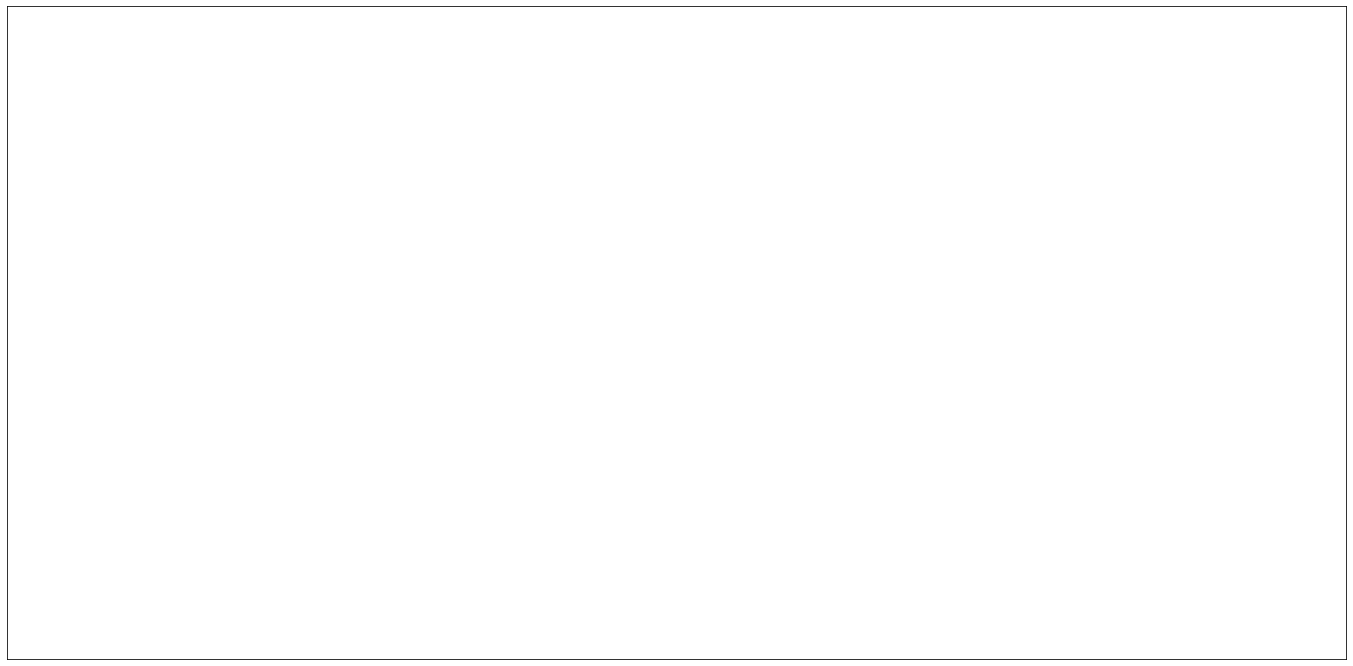

In [14]:
c = load('read_book.pickle')
new = Comp({i:val for i, val in enumerate(list(ins))},verbose=False)
new.reg = c.reg
new.ins = c.ins
new.pnt = c.pnt
new.in_loc = c.in_loc
new.stack = c.stack

# read opcode
from collections import defaultdict
edges = defaultdict(set)
node_names = dict()
jumps = set()
to_check = set([ 5481,6035,6056,6030,6067,6047,6027]) #5491 is the exit
# to_check = set([ 6042,5483 ]) #5491 is the exit
# to_check = set([ 5491]) #5491 is the exit
to_check = set([ 6047, 6056]) #5491 is the exit
to_check = set([ 6067]) #5491 is the exit
# # to_check = set([2952, 25978, 3568, 3599, 2708, 5445, 3]) # decrypt
# to_check = set([1915]) # decrypt
def get_edges(new, pnt):
    new.pnt = pnt
    opcode = new.ins[new.pnt]
    new.pnt += 1
    func, num_write, num_read = new.functions[opcode]
    args = [new.ins[new.pnt+i] for i in range(num_write+num_read)]
    arg_names =[a if a<new.M else f'reg {a%new.M}' for a in args]
    new.pnt += num_write+num_read
    func_name = new.functions[new.ins[pnt]][0].__name__
    if pnt not in node_names:
        node_names[pnt] = f'{pnt} {func_name} {arg_names}'

    # print(func_name)
    if func_name in ['jmp', 'jf','jt', 'call']:
        edges[pnt].add(args[-1])
        # print(args)
        jumps.add((pnt, args[-1]))
        if args[-1] not in edges:
            to_check.add(args[-1])

    if func_name == 'ret': # cannot do nice things with ret
        return

    if func_name not in ['jmp', 'call']:
        edges[pnt].add(new.pnt)
        if new.pnt not in edges:
            to_check.add(new.pnt)
    
START_POS = to_check.pop()
to_check.add(START_POS)
while to_check and len(edges)<30:
    get_edges(new,to_check.pop())

import matplotlib.pyplot as plt
%matplotlib inline

def get_name(pnt):
    return node_names[pnt] if pnt in node_names else f'{pnt} {new.functions[new.ins[pnt]][0].__name__}' if pnt <32768 else 'error'

import networkx as nx

G = nx.DiGraph()
# G.add_nodes_from([get_name(n) for n in node_names])
for k,v in edges.items():
    for pnt in v:
        weight = 'jmp' if (k,pnt) in jumps else ''
        G.add_edge(get_name(k),get_name(pnt), weight=weight)
# color_map = [party_colors[node] for node in G]
pos = nx.nx_agraph.graphviz_layout(G,prog='neato', args ='')

plt.figure(figsize=(24,12))
nx.draw_networkx(G, pos,font_size=12, node_color='y')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,label_pos=0.5, font_size=12)
plt.margins(0.2,0.2)

In [26]:
ins[6067]

18

In [ ]:
magic = 5
reg = {0:4,1:1, 7:magic}
def run()
    if reg[0] != 0: #center 
        if reg[1] != 0:
            #jmp
            stack.append(reg[0])
            reg[1] -= 1
            run()
        else:
            reg[0] -= 1
            reg[1] = reg[7]
            run()
    else: #6027 reg0==0
        reg[0] = reg[1]+1
        if stack[-1] == 5491: 
            print('done, reg[0] should now be 6')
        else:
            GOTO TOP STACK


In [83]:
 5006 6027
pointer 6027 
registers {0: 4, 1: 1, 2: 3, 3: 10, 4: 101, 5: 0, 6: 0, 7: 30000} 
stack [6080, 16, 6124, 1, 2952, 25978, 3568, 3599, 2708, 5445, 3, 5491]
arguments from addresses [32768, 6035]
................ jt (4, 6035)
new pointer 6035

 5006 6027
pointer 6027 
registers {0: 4, 1: 1, 2: 3, 3: 10, 4: 101, 5: 0, 6: 0, 7: 5} 
stack [6080, 16, 6124, 1, 2952, 25978, 3568, 3599, 2708, 5445, 3, 5491]
arguments from addresses [32768, 6035]
................ jt (4, 6035)
new pointer 6035

998

In [86]:
qamHPfkEUpxt
qamHPfkEUpxt
HjbymqFNVYsE
HjbymqFNVYsE
HjbymqFNVYsE
rnneuyhJRoco
HjbymqFNVYsE
CmWvrnAQQVxB
CmWvrnAQQVxB
EIolltGmKvbv
DHniiqJpNwcw
COqLLboAgttp

7

In [71]:
save(c,'pedestal.pickle')

In [198]:
c = load('readyforteleport.pickle')

In [259]:
# solving the calculation puzzle
from itertools import permutations
for comb in permutations([3,9,2,5,7]):
    if comb[0] + comb[1]*(comb[2]**2) + comb[3]**3 - comb[4] == 399:
        print (comb)
        break

(9, 2, 5, 7, 3)


In [7]:
# option 1 to solve final puzzle
cell2val = {2:4,3:4,4:8,5:9,6:11,7:18,8:1}
from aoc_utils import *
from collections import namedtuple
from operator import mul, sub, add
conn = {
    1: ((add,2) , (add, 3), (sub, 3), (sub, 5)),
    2: ((mul, 4),(mul,6),(mul,3), (add,3)),
    3: ((add,2), (mul,2), (mul,4),(mul,6), (sub,6),(sub,5),(sub,7)),
    4: ((mul,2),(mul,3),(mul,6),(sub,6),(sub,8)),
    5: ((sub,3),(sub,7),(mul,7),(sub,6)),
    6: ((mul,2),(mul,3),(sub,3),(mul,4),(sub,4),(sub,5),(sub,7),(mul,7),(mul,8),(sub,8)),
    7: ((sub,3),(sub,5),(mul,5),(sub,6),(mul,6),(mul,8)),
    8: ((sub,4),(sub,6),(mul,6),(mul,7))
}
state = namedtuple('state', ['cell','val'])
options = set()
def getneigh(s):
    for c in conn[s.cell]:
        res = state(c[1], c[0](s.val,cell2val[c[1]]))
        if 0<res.val<100: options.add(res)
    return options
s = state(1,22)
getneigh(s)
bfs(getneigh, start = state(1,22),goal=state(8,30))

[state(cell=1, val=22),
 state(cell=3, val=26),
 state(cell=6, val=15),
 state(cell=3, val=60),
 state(cell=7, val=42),
 state(cell=6, val=31),
 state(cell=8, val=30)]

In [8]:
# option 2 to solve. Easier to code and gives answer fully. Bit more code though
lines = [[mul,8,sub,1],[4,mul,11,mul],[add,4,sub,18],[22,sub,9,mul]]
valid = {(row,col) for row in range(len(lines)) for col in range(len(lines[0]))}
valid.remove((3,0))

from collections import namedtuple
state = namedtuple('state', ['cell','val'])
s = state((3,0),22)
dr = [0,1,0,-1]
dc = [1,0,-1,0]
def getneigh(s):
    r,c = s.cell
    options = set()

    for i in range(4):
        newr = r+dr[i]
        newc = c+dc[i]
        if (newr,newc) in valid:
            if isinstance(lines[newr][newc], int):
                op = lines[r][c]
                # print(op)
                options.add(state((newr,newc),op(s.val,lines[newr][newc])))
            else:
                options.add(state((newr,newc),s.val))
    return options
states = bfs(getneigh, start=s, goal=state((0,3),30))
ans = []

for comb in zippify(states,2):
    dr = comb[1].cell[0] - comb[0].cell[0]
    dc = comb[1].cell[1] - comb[0].cell[1]
    if dr == -1: ans.append('n')
    if dr ==  1: ans.append('s')
    if dc ==  1: ans.append('e')
    if dc == -1: ans.append('w')
print(''.join(ans))

neenwseewnne


In [106]:
def func(k):
  c = [29,31,19,94,2,31,19,17,30,9,3,48,28,4,3,17,7,21,74,31,4,28,25,17,29]
  return [chr((pow(ch,k))%65536) for ch in c]
func(16*7)

['\uf8c1',
 'ሁ',
 '⟁',
 '\x00',
 '\x00',
 'ሁ',
 '⟁',
 '企',
 '\x00',
 '\uf581',
 '닁',
 '\x00',
 '\x00',
 '\x00',
 '닁',
 '企',
 '꺁',
 '䅁',
 '\x00',
 'ሁ',
 '\x00',
 '\x00',
 '첁',
 '企',
 '\uf8c1']

In [104]:
chr(61457623802428291151176307604619059252335431261125297032951727227626804959891359697802810346254769584729613791049421441456286496122769540115504659303709621830351041%65536 )

'\uf8c1'